In [ ]:
#Loading personal Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Library load
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.initializers import TruncatedNormal, VarianceScaling
from keras.layers import LeakyReLU
from keras.layers.core import Dense
from keras.layers.experimental.preprocessing import Normalization
from keras.losses import MeanAbsolutePercentageError
from keras.models import Sequential
from keras.optimizers import Adam

In [ ]:
def data_range_limiter(input_file, output_file, start=0, end=100000):
    with open(input_file) as input:
        with open(output_file, 'w') as output:
            for line in input.readlines():
                items = [float(s) for s in line.split('; ')]
                output_line=''
                for item in items:
                    if item > start and item < end:
                        output_line += '%.4f' % item
                        output_line += '; '
                output_line = output_line[:-2]
                output_line += '\n'
                output.write(output_line)
            output.close()

In [ ]:
#Data preprocessing
data_folder = '/content/drive/MyDrive/StanyWzbudzoneDane/IPA/All/'
experimental_folder = '/content/drive/MyDrive/StanyWzbudzoneDane/Eksperymentalne/'

file_maximas = 'maxima.txt'
file_params = 'params.txt'
file_experimental_maximas = 'experimentallong.txt'

data_range_limiter(data_folder + file_maximas, data_folder + 'maxima_limited.txt', start = 0, end=46300)
data_range_limiter(experimental_folder + file_experimental_maximas, experimental_folder + 'experimental_limited.txt', start = 0, end=46300)

file_maximas = 'maxima_limited.txt'
file_experimental_maximas = 'experimental_limited.txt'

with open(data_folder + file_maximas) as file:
    fexperimental = open(experimental_folder + file_experimental_maximas, 'r')
    todotlen = file.readline().index('.')
    full_len = file.readline().index(';')
    postdotlen = full_len - todotlen
    file.seek(0)
    filler = '; '+ ('0' * (todotlen-1)) + '.' + ('0' * (postdotlen)) + '\n'
    lens = [len(line) for line in file.readlines()]
    lens2 = [len(line) for line in fexperimental.readlines()]
    lens = lens+lens2
    maximalizator = max(lens)
    file_maximalized = open(data_folder + 'maxima_maximalized.txt', 'w')
    file.seek(0)
    for line in file.readlines():
        line_len = len(line)
        while line_len < maximalizator:
            line = line[:-1]+filler
            line_len = len(line)
        file_maximalized.write(line)
    else:
        amount_of_columns = line.count(';')+1
    file_maximalized.close()
    fexperimental.close()
    file.close()

with open(experimental_folder + file_experimental_maximas) as file:
    file_maximalized = open(experimental_folder + 'experimental_maximalized.txt', 'w')
    for line in file.readlines():
        line_len = len(line)
        while line_len < maximalizator:
            line = line[:-1]+filler
            line_len = len(line)
        file_maximalized.write(line)
    file_maximalized.close()
    file.close()


In [ ]:
#Data loading and splitting
preX = np.loadtxt(data_folder + 'maxima_maximalized.txt', delimiter=';')[:,0:amount_of_columns]
Y = np.loadtxt(data_folder + file_params, delimiter=';')[:,0:4]
Z = np.loadtxt(experimental_folder + 'experimental_maximalized.txt', delimiter=';')[:,0:amount_of_columns]

normalizer=Normalization()
normalizer.adapt(preX)
X = normalizer(preX)
Z = normalizer(Z)


training_to_test = int((len(X)/100)*80)

training_x = X[:training_to_test]
test_x = X[training_to_test:]
training_y = Y[:training_to_test]
test_y = Y[training_to_test:]


print('Size of training: %d' % len(training_x))
print('Size of test: %d' % len(test_x))
print('Columns: %d' % amount_of_columns)
print('Shortest row: %d' % ((min(lens)/12)+1))
print('Longest row: %d' % ((max(lens)/12)+1))

Size of training: 26640
Size of test: 6661
Columns: 17
Shortest row: 7
Longest row: 17


In [ ]:
def firstoff(y_true, y_pred):
    loss_value=abs(y_true[0]-y_pred[0])
    return loss_value

def midoff(y_true, y_pred):
    return abs(y_true[1]-y_pred[1])

def lastoff(y_true, y_pred):
    loss_value=abs(y_true[2]-y_pred[2])
    return loss_value

In [ ]:
#Model building
model = Sequential()
model.add(Dense(60, input_dim=amount_of_columns, activation=LeakyReLU(alpha=0.3)))
model.add(Dense(180, activation=LeakyReLU(alpha=0.3), kernel_initializer=VarianceScaling(),
                bias_initializer=TruncatedNormal()))
model.add(Dense(360, activation=LeakyReLU(alpha=0.3), kernel_initializer=VarianceScaling(),
                bias_initializer=TruncatedNormal()))
model.add(Dense(360, activation=LeakyReLU(alpha=0.3), kernel_initializer=VarianceScaling(),
                bias_initializer=TruncatedNormal()))
model.add(Dense(180, activation=LeakyReLU(alpha=0.3), kernel_initializer=VarianceScaling(),
                bias_initializer=TruncatedNormal()))
model.add(Dense(3, activation=LeakyReLU(alpha=0.3), kernel_initializer=VarianceScaling(),
                bias_initializer=TruncatedNormal()))
opt = Adam(learning_rate=0.008)
model.compile(loss=MeanAbsolutePercentageError(), optimizer=opt, metrics=[firstoff, midoff, lastoff])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 60)                1080      
_________________________________________________________________
dense_13 (Dense)             (None, 180)               10980     
_________________________________________________________________
dense_14 (Dense)             (None, 360)               65160     
_________________________________________________________________
dense_15 (Dense)             (None, 360)               129960    
_________________________________________________________________
dense_16 (Dense)             (None, 180)               64980     
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 543       
Total params: 272,703
Trainable params: 272,703
Non-trainable params: 0
________________________________________________

In [ ]:
#Callback defining
callbackPlateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=25,
    verbose=1,
    mode='min',
    min_lr=0.000001,

)

callbackEarly = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0005,
    patience=180,
    restore_best_weights=True,
    verbose=1, 
    mode='auto',)


In [ ]:
#Model training
history = model.fit(
    training_x, 
    training_y, 
    epochs=2500, 
    batch_size=128, 
    callbacks=[callbackPlateau, callbackEarly], 
    validation_split=0.1
    )

Epoch 1/2500
188/188 [==============================] - 2s 4ms/step - loss: 49.8622 - firstoff: 113.8278 - midoff: 113.8597 - lastoff: 113.7968 - val_loss: 7.7455 - val_firstoff: 5.3267 - val_midoff: 5.9436 - val_lastoff: 5.7215
Epoch 2/2500
188/188 [==============================] - 1s 3ms/step - loss: 5.8040 - firstoff: 4.1081 - midoff: 3.7761 - lastoff: 4.2855 - val_loss: 6.5566 - val_firstoff: 2.2760 - val_midoff: 2.5258 - val_lastoff: 2.8976
Epoch 3/2500
188/188 [==============================] - 1s 3ms/step - loss: 6.2467 - firstoff: 3.3875 - midoff: 4.4254 - lastoff: 3.6911 - val_loss: 3.9042 - val_firstoff: 2.8228 - val_midoff: 2.6232 - val_lastoff: 2.9062
Epoch 4/2500
188/188 [==============================] - 1s 4ms/step - loss: 3.6520 - firstoff: 2.8827 - midoff: 2.8416 - lastoff: 2.3097 - val_loss: 5.1845 - val_firstoff: 2.2353 - val_midoff: 2.1821 - val_lastoff: 2.4257
Epoch 5/2500
188/188 [==============================] - 1s 4ms/step - loss: 3.4611 - firstoff: 2.4991 - m

In [ ]:
#Model evaluation
model.evaluate(test_x, test_y, batch_size=128)
predictions = model.predict(test_x)

for i in range(15):
    print('%s; %s; %s (expected %s; %s; %s), first off: %.4f, midoff: %.4f, lastoff: %.4f ' % (
    predictions[i][0], predictions[i][1], predictions[i][2], 
    test_y[i][0], test_y[i][1], test_y[i][2],
    firstoff(test_y[i], predictions[i]),
    midoff(test_y[i], predictions[i]),
    lastoff(test_y[i], predictions[i])
    ))

#Worst prediction abs_diff
all_pred_first = [firstoff(test_y[i],predictions[i]) for i in range(len(predictions))]
all_pred_mid = [midoff(test_y[i],predictions[i]) for i in range(len(predictions))]
all_pred_last = [lastoff(test_y[i],predictions[i]) for i in range(len(predictions))]
worst_pred = max(all_pred_first)
i = all_pred_first.index(worst_pred)

bad_pred_firstlast_indexes = [all_pred_first.index(x) for x in all_pred_first if x>0.0035]
bad_pred_mid_indexes = [all_pred_mid.index(x) for x in all_pred_mid if x>2]
bad_pred_indexes = list(set(bad_pred_mid_indexes + bad_pred_firstlast_indexes))
print('\n Worst:')
print('%s; %s; %s (expected %s; %s; %s), first off: %.4f, midoff: %.4f, lastoff: %.4f ' % (
    predictions[i][0], predictions[i][1], predictions[i][2], 
    test_y[i][0], test_y[i][1], test_y[i][2],
    firstoff(test_y[i], predictions[i]),
    midoff(test_y[i], predictions[i]),
    lastoff(test_y[i], predictions[i])
    ))
bad_x = [X[i] for i in bad_pred_indexes]
print('\n Bad abs diff: '+ str(len(bad_pred_indexes)) + ' = ' + str(round((len(bad_pred_indexes)/len(all_pred_firstlast))*100, 2)) + '%')

for i in bad_pred_indexes:
    print('%s; %s; %s (expected %s; %s; %s), 1,3 off: %.4f, midoff: %.4f ' % (
        predictions[i][0], predictions[i][1], predictions[i][2], 
        test_y[i][0], test_y[i][1], test_y[i][2],
        firstlastoff(test_y[i], predictions[i]),
        midoff(test_y[i], predictions[i])
        ))

print("Hello")

prediction_exp = model.predict(Z)
for i in range(len(prediction_exp)):
    print(str(prediction_exp[i][0]),  str(prediction_exp[i][1]),  str(prediction_exp[i][2]))
    


53/53 [==============================] - 0s 3ms/step - loss: 0.1340 - firstoff: 0.7431 - midoff: 0.5628 - lastoff: 0.4775
3.6349661; 380.71472; 1.287938 (expected 3.635; 380.3682; 1.288358), first off: 0.0000, midoff: 0.3465, lastoff: 0.0004 
3.5080538; 372.52213; 1.250401 (expected 3.5105; 382.1356; 1.240465), first off: 0.0024, midoff: 9.6135, lastoff: 0.0099 
3.572666; 376.08618; 1.2515475 (expected 3.5727; 371.2908; 1.255524), first off: 0.0000, midoff: 4.7954, lastoff: 0.0040 
3.6987128; 381.2067; 1.2484527 (expected 3.6988; 381.0875; 1.248322), first off: 0.0001, midoff: 0.1192, lastoff: 0.0001 
3.5263247; 372.69147; 1.213113 (expected 3.5259; 371.4707; 1.21444), first off: 0.0004, midoff: 1.2208, lastoff: 0.0013 
3.5292015; 382.51645; 1.3527143 (expected 3.5292; 382.7101; 1.352295), first off: 0.0000, midoff: 0.1937, lastoff: 0.0004 
3.6736937; 370.592; 1.3093371 (expected 3.6737; 370.7053; 1.309319), first off: 0.0000, midoff: 0.1133, lastoff: 0.0000 
3.6237078; 372.0023; 1.406

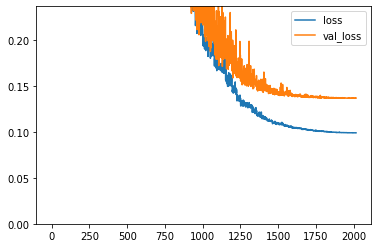

In [ ]:
#Model history plotting
plt.plot(history.history['loss'], label='loss')
plt.ylim(0, history.history['val_loss'][-1]+0.1)
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()